# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [27]:
%matplotlib inline

In [28]:
from __future__ import print_function

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [30]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [31]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [32]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [33]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(torch.tensor([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = torch.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * torch.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * torch.eye(dynamics.state_size)

# Instantaneous control cost.
R = torch.tensor([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [36]:
N = 500
x0 = dynamics.augment_state(torch.tensor([0.0, 0.0, np.pi, 0.0]))
us_init = torch.rand((N, dynamics.action_size)) * 2 - 1
ilqr = iLQR(dynamics, cost, N)

In [37]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

AttributeError: 'Tensor' object has no attribute 'copy'

In [18]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [19]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

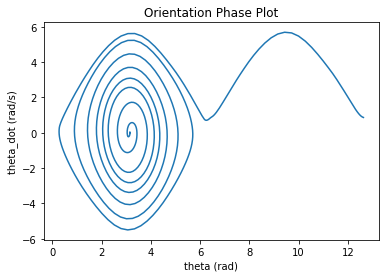

In [20]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

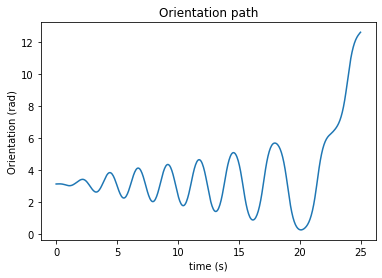

In [21]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

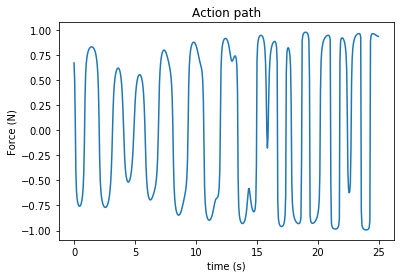

In [22]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

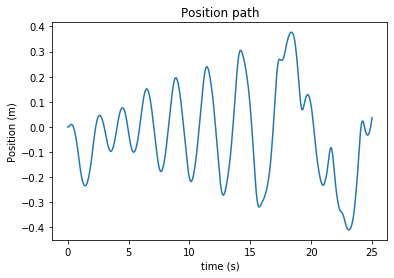

In [23]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

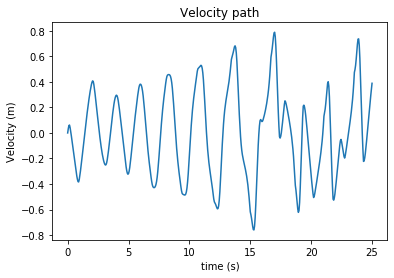

In [24]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

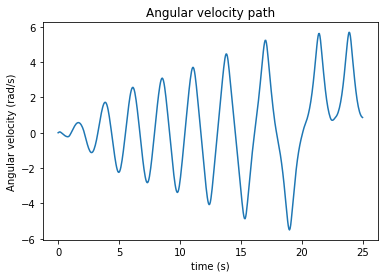

In [25]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

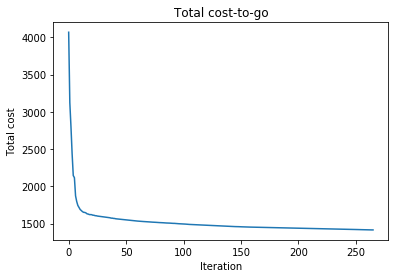

In [26]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")